# CIFAR-10 Model Performance Evaluation

This notebook evaluates the performance of our trained ResNet model on the CIFAR-10 dataset. We'll calculate and visualize:
1. Model Accuracy, Precision, Recall, and F1-score
2. Confusion Matrix
3. Training History (if available)
4. Save all metrics for future reference

In [6]:
# Import required libraries
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from torchvision import transforms
import sys
import os

# Add src directory to path
sys.path.append('./src')
from model import get_model
from dataset import get_dataloaders

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load model and data
def load_model_and_data(batch_size=256):  # Increased batch size for faster processing
    print("Loading data and model...")
    train_loader, test_loader, classes = get_dataloaders(batch_size=batch_size)
    print("Data loaders created")
    
    print("Loading model...")
    model = get_model(num_classes=len(classes), pretrained=False)
    model.load_state_dict(torch.load('src/models/resnet_cifar10.pth', map_location=device))
    model = model.to(device)
    model.eval()
    print("Model loaded successfully")
    return model, test_loader, classes

print("Starting model and data loading...")
model, test_loader, classes = load_model_and_data()

Using device: cpu
Starting model and data loading...
Loading data and model...
Data loaders created
Loading model...
Data loaders created
Loading model...


s:\university\7th semeseter\deep learning\final project\project IEA\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
s:\university\7th semeseter\deep learning\final project\project IEA\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model loaded successfully


## Calculate Model Metrics

Let's evaluate the model on the test set and calculate various performance metrics:

In [7]:
# Evaluate model on test set
def evaluate_model(model, test_loader):
    all_preds = []
    all_targets = []
    total_batches = len(test_loader)
    print(f"Starting evaluation on {total_batches} batches...")
    
    with torch.no_grad():
        for i, (images, targets) in enumerate(test_loader, 1):
            if i % 10 == 0:  # Print progress every 10 batches
                print(f"Processing batch {i}/{total_batches}")
            
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.numpy())
    
    print("Evaluation completed!")
    return np.array(all_preds), np.array(all_targets)

print("Starting model evaluation...")
y_pred, y_true = evaluate_model(model, test_loader)

print("\nCalculating metrics...")
# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

# Create metrics DataFrame
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Value': [accuracy, precision, recall, f1]
})

print("\nModel Performance Metrics:")
print(metrics_df.to_string(index=False))

Starting model evaluation...
Starting evaluation on 40 batches...
Processing batch 10/40
Processing batch 10/40
Processing batch 20/40
Processing batch 20/40
Processing batch 30/40
Processing batch 30/40
Processing batch 40/40
Processing batch 40/40
Evaluation completed!

Calculating metrics...

Model Performance Metrics:
   Metric    Value
 Accuracy 0.786900
Precision 0.794539
   Recall 0.786900
 F1-Score 0.785045
Evaluation completed!

Calculating metrics...

Model Performance Metrics:
   Metric    Value
 Accuracy 0.786900
Precision 0.794539
   Recall 0.786900
 F1-Score 0.785045


## Confusion Matrix

Now let's create and visualize the confusion matrix to see how well the model performs for each class:

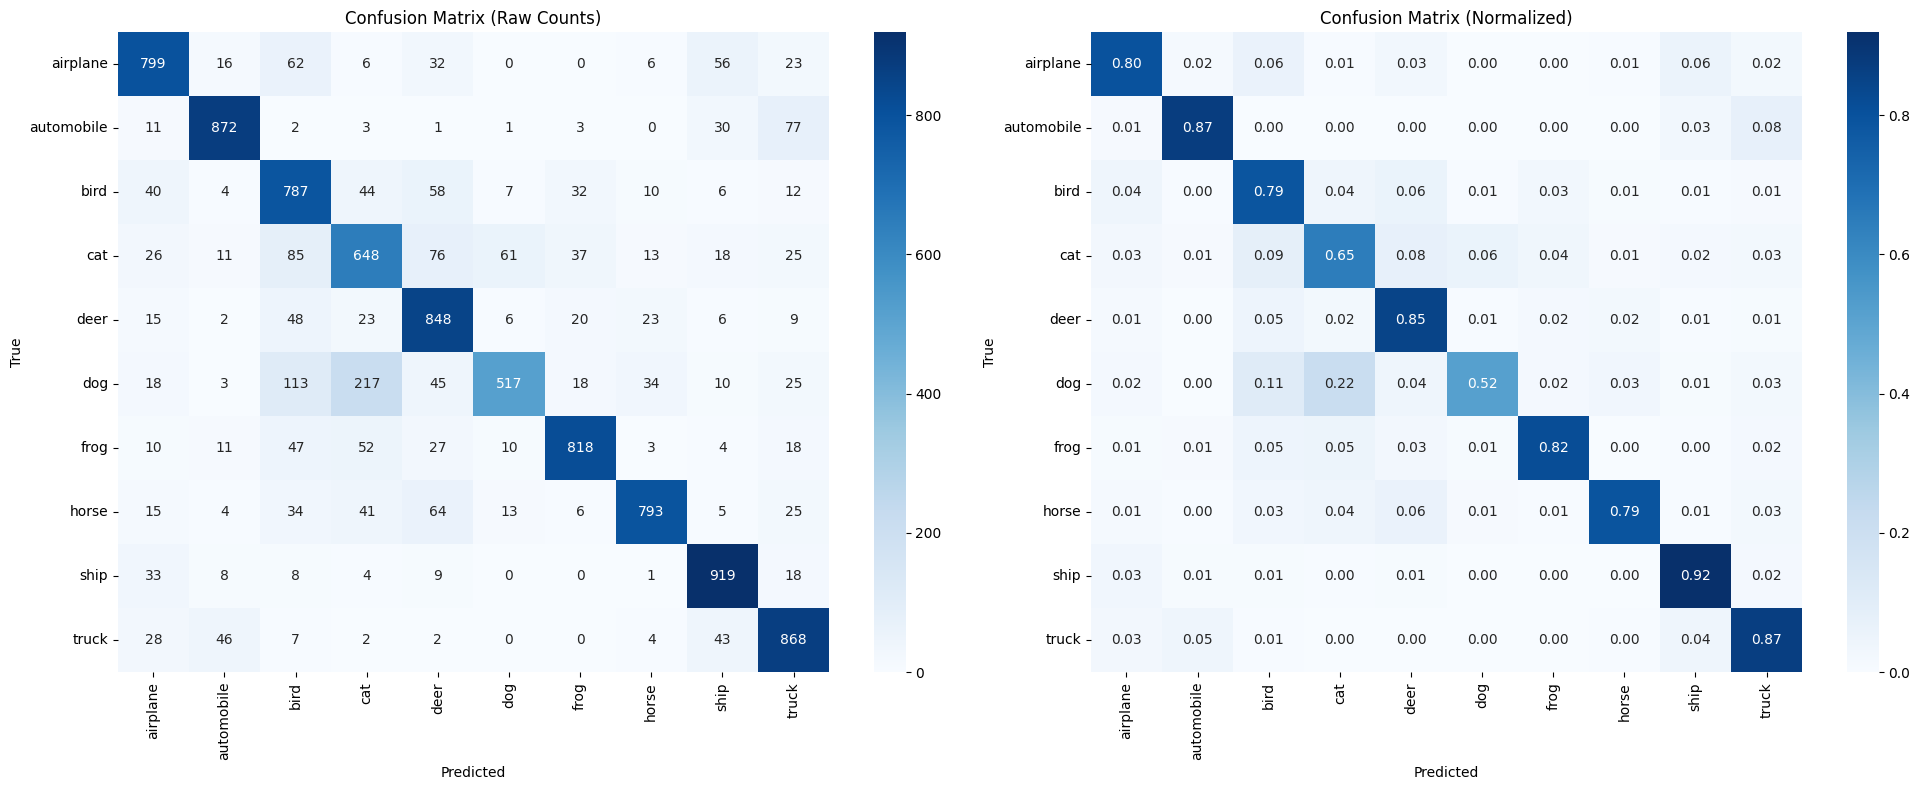

In [8]:
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create confusion matrix plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, 
            yticklabels=classes, ax=ax1)
ax1.set_title('Confusion Matrix (Raw Counts)')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('True')

# Normalized
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, 
            yticklabels=classes, ax=ax2)
ax2.set_title('Confusion Matrix (Normalized)')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('True')

plt.tight_layout()
plt.show()

## Per-Class Performance

Let's analyze the model's performance for each class:

Per-Class Performance Metrics:
     Class  Precision  Recall  F1-Score  Support
  airplane   0.803015   0.799  0.801003     1000
automobile   0.892528   0.872  0.882145     1000
      bird   0.659681   0.787  0.717738     1000
       cat   0.623077   0.648  0.635294     1000
      deer   0.729776   0.848  0.784459     1000
       dog   0.840650   0.517  0.640248     1000
      frog   0.875803   0.818  0.845915     1000
     horse   0.894025   0.793  0.840488     1000
      ship   0.837739   0.919  0.876490     1000
     truck   0.789091   0.868  0.826667     1000


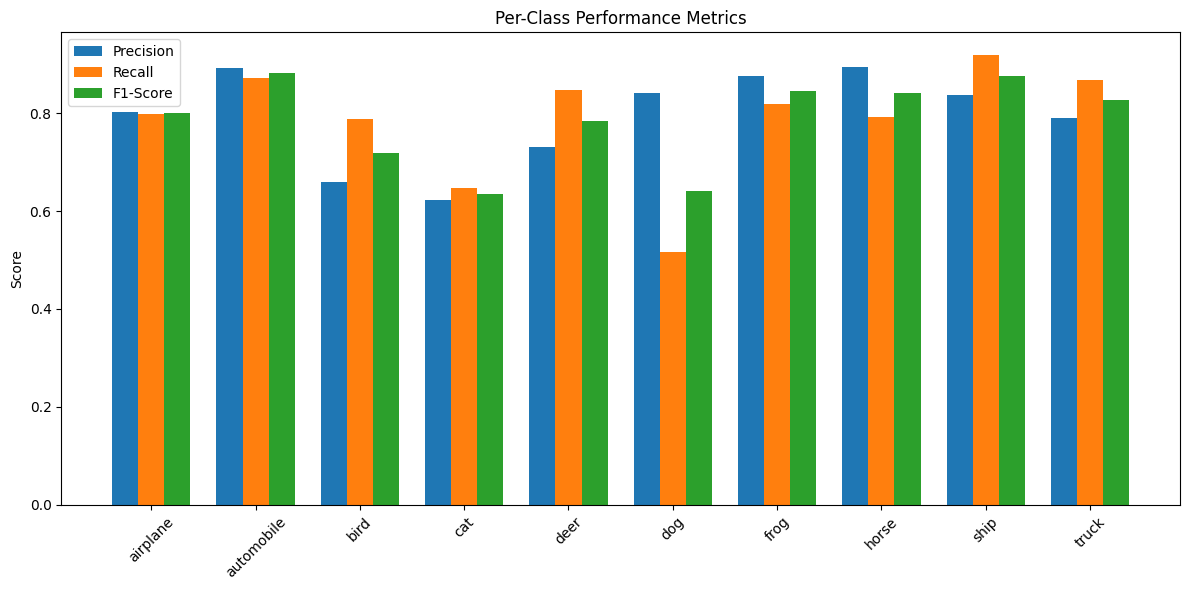

In [9]:
# Calculate per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred)

# Create per-class metrics DataFrame
per_class_metrics = pd.DataFrame({
    'Class': classes,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

print("Per-Class Performance Metrics:")
print(per_class_metrics.to_string(index=False))

# Plot per-class metrics
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(classes))
width = 0.25

ax.bar(x - width, precision, width, label='Precision')
ax.bar(x, recall, width, label='Recall')
ax.bar(x + width, f1, width, label='F1-Score')

ax.set_ylabel('Score')
ax.set_title('Per-Class Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=45)
ax.legend()

plt.tight_layout()
plt.show()

## Save Performance Metrics

Finally, let's save all the calculated metrics to a file for future reference:

In [10]:
# Save metrics to file
metrics_path = 'results/metrics.txt'
os.makedirs('results', exist_ok=True)

with open(metrics_path, 'w') as f:
    # Overall metrics
    f.write("=== Overall Model Performance ===\n")
    f.write(metrics_df.to_string())
    f.write("\n\n")
    
    # Per-class metrics
    f.write("=== Per-Class Performance ===\n")
    f.write(per_class_metrics.to_string())
    f.write("\n\n")
    
    # Confusion Matrix
    f.write("=== Confusion Matrix ===\n")
    f.write("Raw Counts:\n")
    f.write(pd.DataFrame(cm, columns=classes, index=classes).to_string())
    f.write("\n\nNormalized:\n")
    f.write(pd.DataFrame(cm_norm, columns=classes, index=classes).round(3).to_string())

print(f"Metrics saved to {metrics_path}")

# Display the contents of the saved file
with open(metrics_path, 'r') as f:
    print("\nContents of metrics.txt:")
    print(f.read())

Metrics saved to results/metrics.txt

Contents of metrics.txt:
=== Overall Model Performance ===
      Metric     Value
0   Accuracy  0.786900
1  Precision  0.794539
2     Recall  0.786900
3   F1-Score  0.785045

=== Per-Class Performance ===
        Class  Precision  Recall  F1-Score  Support
0    airplane   0.803015   0.799  0.801003     1000
1  automobile   0.892528   0.872  0.882145     1000
2        bird   0.659681   0.787  0.717738     1000
3         cat   0.623077   0.648  0.635294     1000
4        deer   0.729776   0.848  0.784459     1000
5         dog   0.840650   0.517  0.640248     1000
6        frog   0.875803   0.818  0.845915     1000
7       horse   0.894025   0.793  0.840488     1000
8        ship   0.837739   0.919  0.876490     1000
9       truck   0.789091   0.868  0.826667     1000

=== Confusion Matrix ===
Raw Counts:
            airplane  automobile  bird  cat  deer  dog  frog  horse  ship  truck
airplane         799          16    62    6    32    0     0      